# Bayesian Final Project
# Crisis Management using Tweets
### Sana Syed - ss8xj
### Sucheta Sharma - ss4jg
### Haritha Guttikonda - hg5mn

In [1]:
import sys
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import arviz as az
import scipy.stats as stats
import scipy as sp
import matplotlib.pyplot as plt
import graphviz
from dbn.tensorflow import SupervisedDBNClassification

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
from pybbn.generator.bbngenerator import convert_for_drawing
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# command to install dbn.tensorflow package
#!pip install git+git://github.com/albertbup/deep-belief-network.git

# Data Preprocessing

In [3]:
# load two csv files and merge them
wild_fires_data = pd.read_csv("2012_Colorado_wildfires-tweets_labeled.csv")
wild_fires_australia_data = pd.read_csv("2013_Australia_bushfire-tweets_labeled.csv")
wild_fires_data = [wild_fires_data,wild_fires_australia_data]
wild_fires_data = pd.concat(wild_fires_data)

In [4]:
wild_fires_data.head()

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness
0,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related
1,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related
2,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related
3,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related
4,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related


In [5]:
# drop tweet ID and Information source
columns = ['Tweet ID', ' Information Source']
wild_fires_data.drop(columns, inplace=True, axis=1)

In [6]:
wild_fires_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2399 entries, 0 to 1198
Data columns (total 3 columns):
 Tweet Text          2399 non-null object
 Information Type    2399 non-null object
 Informativeness     2399 non-null object
dtypes: object(3)
memory usage: 75.0+ KB


In [7]:
wild_fires_data[' Informativeness'] = wild_fires_data[' Informativeness'].astype('category')

In [8]:
# function to convert the categories in informativeness column to integer classes.
def Informativeness_to_numeric(x):
    if x=='Related and informative':
        return 3
    if x=='Not related':
        return 2
    if x=='Related - but not informative':
        return 1
    if x=='Not applicable':
        return 4

In [9]:
wild_fires_data[' Informativeness'] = wild_fires_data[' Informativeness'].apply(Informativeness_to_numeric)
wild_fires_data.head()

,Tweet Text,Information Type,Informativeness
0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,2
1,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,2
2,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,2
3,Denver Post: #Colorado governor signs bill cre...,Not labeled,2
4,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,2


In [10]:
# extract rows that have information type as not labelled 
# we wont consider these rows as we are doing supervised classification which requires our data to be labelled
not_labelled = wild_fires_data[wild_fires_data[' Information Type'] == 'Not labeled']
not_labelled.head()

,Tweet Text,Information Type,Informativeness
0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,2
1,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,2
2,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,2
3,Denver Post: #Colorado governor signs bill cre...,Not labeled,2
4,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,2


In [11]:
# extract labelled data
labelled = wild_fires_data[wild_fires_data[' Information Type'] != 'Not labeled']
labelled.head()

,Tweet Text,Information Type,Informativeness
14,RT @northfortynews: Tanker helicopter heads up...,Other Useful Information,3
16,#Evacuation center Cache La Poudre Middle Scho...,Caution and advice,3
19,20F degrees cooler tomorrow in North Central &...,Other Useful Information,3
21,FEMA has authorized the use of federal funds t...,Other Useful Information,3
22,#Media Large wildfire in N. Colorado prompts e...,Affected individuals,3


In [12]:
# categories in information type
np.unique(labelled[' Information Type'])

array(['Affected individuals', 'Caution and advice',
       'Donations and volunteering', 'Infrastructure and utilities',
       'Not applicable', 'Other Useful Information',
       'Sympathy and support'], dtype=object)

In [13]:
# function to convert information type to integer classes
def Information_Type_to_numeric(x):
    if x=='Affected individuals':
        return 3
    if x=='Caution and advice':
        return 2
    if x=='Donations and volunteering':
        return 1
    if x=='Infrastructure and utilities':
        return 4
    if x=='Not applicable':
        return 5
    if x=='Other Useful Information':
        return 6
    if x=='Sympathy and support':
        return 7
    

In [14]:
labelled[' Information Type'] = labelled[' Information Type'].apply(Information_Type_to_numeric)
labelled.head()

/Users/haritha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Tweet Text,Information Type,Informativeness
14,RT @northfortynews: Tanker helicopter heads up...,6,3
16,#Evacuation center Cache La Poudre Middle Scho...,2,3
19,20F degrees cooler tomorrow in North Central &...,6,3
21,FEMA has authorized the use of federal funds t...,6,3
22,#Media Large wildfire in N. Colorado prompts e...,3,3


In [15]:
labelled.shape

(1902, 3)

# Nested Naive Bayes Classifier

In [16]:
# function to implement nested naive bayes
def nested_classify_nb(X_train, X_test, y_train, y_test, latent_train, latent_test):
    # fit two naive bayes models
    mnb1 = MultinomialNB()
    mnb1.fit(X_train, latent_train)
    cv_predicted = cross_val_predict(mnb1, X_train, latent_train, cv=LeaveOneOut())
    print ("Naive Bayes Training accuracy for Informativeness prediction: ", accuracy_score(latent_train, cv_predicted))
    
    
    mnb2 = MultinomialNB()
    mnb2.fit(X_train, y_train)
    cv_predicted = cross_val_predict(mnb2, X_train, y_train, cv=LeaveOneOut())
    print ("Naive Bayes Training accuracy for Information Type prediction: ", accuracy_score(y_train, cv_predicted))
    
    # predict class for first classifier
    pred1 = mnb1.predict(X_test)
    
    # extract indices where the predicted class is 3(related and informative)
    indices = np.where( pred1 == 3 )
    y_test_ri = y_test.iloc[indices]
    X_test_ri = X_test[indices]
    pred2 = []
    count = 0
    # predict class for second classifier only when the first predicted class is 3 
    for i in range(len(pred1)):
        if pred1[i] == 3:
            x_test = X_test_ri[count]
            pred2.append(mnb2.predict(x_test))
            count = count + 1
            print("Tweet ", i+1, " is informative with info type ", mnb2.predict(x_test))
        else:
            print("Tweet ", i+1, " is not informative!")
    
        
    print("Accuracy of the Classifier given the tweet is Informative is: ", accuracy_score(y_test_ri, pred2))
    print("Accuracy of the Classifier given the tweet is Informative is: ", accuracy_score(latent_test, pred1))

In [17]:
X = labelled.loc[:,' Tweet Text']
y = labelled.loc[:, ' Information Type']
latent = labelled.loc[:, ' Informativeness']

X_train, X_test, latent_train, latent_test = train_test_split(X, latent, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# count vectorizer to get bag of words from the tweets
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

nested_classify_nb(X_train_cv, X_test_cv, y_train, y_test, latent_train, latent_test)

Naive Bayes Training accuracy for Informativeness prediction:  0.8183730715287517
Naive Bayes Training accuracy for Information Type prediction:  0.6423562412342216
Tweet  1  is informative with info type  [2]
Tweet  2  is not informative!
Tweet  3  is not informative!
Tweet  4  is informative with info type  [6]
Tweet  5  is informative with info type  [6]
Tweet  6  is informative with info type  [6]
Tweet  7  is informative with info type  [6]
Tweet  8  is informative with info type  [6]
Tweet  9  is informative with info type  [6]
Tweet  10  is not informative!
Tweet  11  is informative with info type  [6]
Tweet  12  is not informative!
Tweet  13  is informative with info type  [6]
Tweet  14  is informative with info type  [6]
Tweet  15  is informative with info type  [6]
Tweet  16  is informative with info type  [6]
Tweet  17  is informative with info type  [6]
Tweet  18  is informative with info type  [4]
Tweet  19  is not informative!
Tweet  20  is informative with info type  [6]

Tweet  417  is informative with info type  [2]
Tweet  418  is informative with info type  [2]
Tweet  419  is not informative!
Tweet  420  is informative with info type  [6]
Tweet  421  is informative with info type  [6]
Tweet  422  is informative with info type  [3]
Tweet  423  is informative with info type  [6]
Tweet  424  is informative with info type  [6]
Tweet  425  is informative with info type  [6]
Tweet  426  is not informative!
Tweet  427  is informative with info type  [6]
Tweet  428  is informative with info type  [6]
Tweet  429  is informative with info type  [6]
Tweet  430  is not informative!
Tweet  431  is informative with info type  [6]
Tweet  432  is not informative!
Tweet  433  is informative with info type  [6]
Tweet  434  is not informative!
Tweet  435  is informative with info type  [2]
Tweet  436  is not informative!
Tweet  437  is informative with info type  [6]
Tweet  438  is informative with info type  [6]
Tweet  439  is informative with info type  [6]
Tweet  44

# Deep Belief Network Classification

In [18]:
# input and output for the dep belief network
X = cv.fit_transform(labelled.loc[:,' Tweet Text'])
X = X.toarray()
X = pd.DataFrame(X)
Y = labelled[' Information Type']

In [19]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X = ss.fit_transform(X)

In [20]:
# train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [21]:
# building a deep belief network model with three hidden layers containing 250 units each
# no. of epochs for each ristricted boltzmann machine is 10
# activation function used is relu. can use sigmoid too
classifier = SupervisedDBNClassification(hidden_layers_structure = [250, 250, 250],
learning_rate_rbm=0.05,
learning_rate=0.1,
n_epochs_rbm=10,
n_iter_backprop=100,
batch_size=200,
activation_function='relu',
dropout_p=0.2)

In [22]:
# fit model
classifier.fit(X_train, Y_train)

[START] Pre-training step:



Instructions for updating:
Use `tf.cast` instead.

>> Epoch 1 finished 	RBM Reconstruction error 5485.958003
>> Epoch 2 finished 	RBM Reconstruction error 5258.293810
>> Epoch 3 finished 	RBM Reconstruction error 4865.735960
>> Epoch 4 finished 	RBM Reconstruction error 4405.781388
>> Epoch 5 finished 	RBM Reconstruction error 4002.114105
>> Epoch 6 finished 	RBM Reconstruction error 3838.718420
>> Epoch 7 finished 	RBM Reconstruction error 4065.500010
>> Epoch 8 finished 	RBM Reconstruction error 4885.005873
>> Epoch 9 finished 	RBM Reconstruction error 6484.304885
>> Epoch 10 finished 	RBM Reconstruction error 9050.920034
>> Epoch 1 finished 	RBM Reconstruction error 6587.160645
>> Epoch 2 finished 	RBM Reconstruction error 6248.280273
>> Epoch 3 finished 	RBM Reconstruction error 6093.633789
>> Epoch 4 finished 	RBM Reconstruction error 6021.956543
>> Epoch 5 finished 	RBM Reconstruction error 5987.742188
>> Epoch 6 finished 	RBM Reconstruction error 59

>> Epoch 99 finished 	ANN training loss 1.637986
[END] Fine tuning step


SupervisedDBNClassification(batch_size=200, dropout_p=0.2,
                            idx_to_label_map={0: 4, 1: 3, 2: 7, 3: 2, 4: 6,
                                              5: 1, 6: 5},
                            l2_regularization=1.0,
                            label_to_idx_map={1: 5, 2: 3, 3: 1, 4: 0, 5: 6,
                                              6: 4, 7: 2},
                            learning_rate=0.1, n_iter_backprop=100,
                            verbose=True)

In [23]:
# predict from the model
Y_pred = classifier.predict(X_test)
print('Done.\nAccuracy: %f' % accuracy_score(Y_test, Y_pred))

Done.
Accuracy: 0.482940


# Bayesian Belief Network

In [24]:
# creating Bayesian belief network nodes by initilizing number of random states in each random variable 
# and their respective transition probabilities 
Info_Source = BbnNode(Variable(0,
                              'Info_Source',
                              ['Business', 'Eyewitness','Government', 'Media', 'NGOs', 'Outsiders']),
                              [0.01066, 0.069, 0.078, 0.48, 0.0511, 0.308])
Informativeness = BbnNode(Variable(1, 
                                  'Informativeness',
                                  ['Related_Informative', 'Related_Not_Informative']),
                                  [0.8, 0.2, 0.54, 0.46, 0.85, 0.15, 0.92, 0.08, 0.75, 0.25, 0.42, 0.58])
Info_Type = BbnNode(Variable(2,
                            'Info_Type', 
                            ['Affected Individuals', 'Caution', 'Donations', 'Infra', 'Other', 'Sympathy']), 
                            [0.18, 0.064, 0.089, 0.1, 0.52, 0.04, 0.089, 0.0038, 0.062, 0.0077, 0.26, 0.569])



In [25]:
# building a network with 3 nodes and 2 edges specifying the conditional relationship between the nodes
bbn1 = Bbn() \
    .add_node(Info_Source) \
    .add_node(Informativeness) \
    .add_node(Info_Type) \
    .add_edge(Edge(Info_Source, Informativeness, EdgeType.DIRECTED)) \
    .add_edge(Edge(Informativeness, Info_Type, EdgeType.DIRECTED))

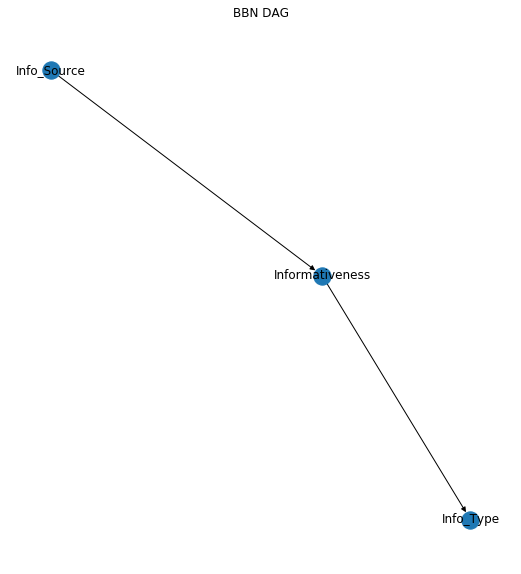

In [26]:
# plotting the belief network 
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn1)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(20, 10))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn1.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')
    plt.savefig('DAG')

In [27]:
# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn1)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('Info_Source')) \
    .with_evidence('Outsiders', 1.0) \
    .build()

join_tree.set_observation(ev)

# print the marginal probabilities 
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)
    print('--------------------->') 

1|Informativeness|Related_Informative,Related_Not_Informative
1=Related_Informative|0.42037
1=Related_Not_Informative|0.57963
--------------------->
0|Info_Source|Business,Eyewitness,Government,Media,NGOs,Outsiders
0=Business|0.00000
0=Eyewitness|0.00000
0=Government|0.00000
0=Media|0.00000
0=NGOs|0.00000
0=Outsiders|1.00000
--------------------->
2|Info_Type|Affected Individuals,Caution,Donations,Infra,Other,Sympathy
2=Affected Individuals|0.12823
2=Caution|0.02931
2=Donations|0.07392
2=Infra|0.04683
2=Other|0.37213
2=Sympathy|0.34957
--------------------->


In [28]:
# convert the BBN to a join tree
join_tree = InferenceController.apply(bbn1)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('Info_Source')) \
    .with_evidence('Government', 1.0) \
    .build()

join_tree.set_observation(ev)

# print the marginal probabilities
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)
    print('--------------------->') 

1|Informativeness|Related_Informative,Related_Not_Informative
1=Related_Informative|0.85019
1=Related_Not_Informative|0.14981
--------------------->
0|Info_Source|Business,Eyewitness,Government,Media,NGOs,Outsiders
0=Business|0.00000
0=Eyewitness|0.00000
0=Government|1.00000
0=Media|0.00000
0=NGOs|0.00000
0=Outsiders|0.00000
--------------------->
2|Info_Type|Affected Individuals,Caution,Donations,Infra,Other,Sympathy
2=Affected Individuals|0.16756
2=Caution|0.05537
2=Donations|0.08557
2=Infra|0.08678
2=Other|0.48450
2=Sympathy|0.12022
--------------------->
